ChEn-5310: Computational Continuum Transport Phenomena Spring 2021 UMass Lowell; Prof. V. F. de Almeida **25Jan21**

# 01. Introduction
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
$

---

## Table of Contents<a id="toc"></a>
* [Objectives](#obj)
* [Least-Squares Approximation w/ Fourier Basis Functions](#lsq)
  - [Collocation Points](#colpts)
  - [Linear Combination of Basis Functions](#lincomb)
  - [Least-Squares of Residual](#lsqcalc)
  - [Results](#res)
  - [Errors](#error)
* [Least-Squares Approximation w/ Polynomial Basis Functions](#poly)
  - [Results](#polyres)
  - [Errors](#error)
---

## [Objectives](#toc)<a id="obj"></a>

 + Introductory comments on variational forms and basis functions.
 + Elementary use of basis functions to approximate a given function: linear least-squares method
 + Elementary description of a least-squares Galerkin spectral element method to solve 1-D Poisson problem.
 + [Handwritten notes in OneNote](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/EiT9S8dWWQ5LuvalDfeDuOoBs-_tgLPFR83xU6WumdI9xg?e=fQXd40).

## [Least-Squares Approxmation w/ Fourier Basis Functions](#toc)<a id="lsq"></a>

Given a *well-behaved* function $f:\Reals\rightarrow\Reals$ how can we systematically compute an approximant $g:\Reals\rightarrow\Reals$? Why would anyone care about this? The ability to approximate a given $f$ helps build methods to approximate $f$ when it is not explicitly given but sought as the solution of a mathematical problem such as an ODE or PDE.

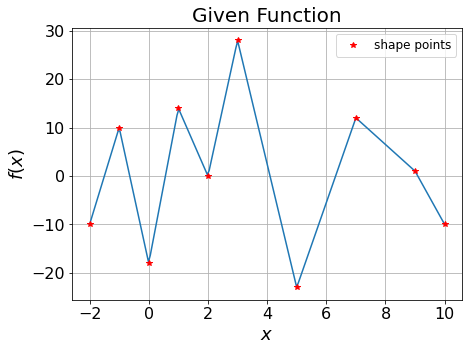

In [1]:
'''Generate a smooth function f'''

try:    
    from engy_5310.toolkit import Function   
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

shape_pts = [(-2,-10),(-1,10),(0,-18),(1,14),(2,0),(3,28),(5,-23),(7,12),(9,1),(10,-10)]

f = Function(shape_pts, type='linear')
  
f.plot(n_plot_pts=200, shape_pts=True, title='Given Function')

In [2]:
'''Example code for plotting (not used)'''
import matplotlib.pyplot as plt
%matplotlib inline
def plot(f, g=None, n_plot_pts=100, shape_pts=False):
    
    x = np.linspace(f.shape_pts[0][0], f.shape_pts[-1][0], n_plot_pts)
    y = f.values(x)
    
    plt.figure(1, figsize=(7, 5))

    if g:
        plt.plot(x, y, label='f')
    else:
        plt.plot(x, y)
    
    if shape_pts:
        plt.plot([p[0] for p in f.shape_pts], [p[1] for p in f.shape_pts],'r*',label='shape points')
    
    if g:
        plt.plot(g[0], g[1], '--r', label='g')
    
    plt.xlabel(r'$x$',fontsize=18)
    if g:
        plt.ylabel(r'$f(x), g(x)$', fontsize=18)
    else:
        plt.ylabel(r'$f(x)$', fontsize=18)
    
    if g:
        plt.title('Function Comparison', fontsize=20)
    else:
        plt.title('Given Function',fontsize=20)
        
    if shape_pts or g:
        plt.legend(loc='best',fontsize=12)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.show()

### [Collocation Points](#toc)<a id="colpts"></a>

If $g$ is obtainable, how would we compare to $f$? On the whole $\Reals$? This prompts the simple idea of computing $g$ to approximate $f$ on a selected number of points in $\Reals$. Hence, let's select a number of *collocation* abscissa points and form the *set* $\{x_i \mid i=1,\ldots,m\}$. Now we can ask a more definite question. How do we make $g$ and $f$ to be very close when evaluated at the collocation points? Ideally if $m\rightarrow\infty$ then $f\approx g$ to a good extent.

In [3]:
'''Collocation abscissa points'''
import numpy as np

min_x = shape_pts[0][0]
max_x = shape_pts[-1][0]
m = 80

collocation_pts = np.linspace(min_x, max_x, m)

### [Linear Combination of Basis Functions](#toc)<a id="lincomb"></a>

A powerful method used to compute an approximant $g$ can be built using a simple structure of a basis function set, for example

\begin{equation*}
   V := \{\cos(k\,\mu\,x), \,\sin(k\,\mu\,x)\, \mid \, k=0,\ldots,N\}.
\end{equation*}

This will be referred to as a Fourier basis function set. An approximant $g$ can be sougth as a **linear combination** of nonlinear functions:

\begin{equation*}
 g(x) := \sum\limits_{k=0}^N \alpha_k\,\cos(k\,\mu\,x) + \beta_k\,\sin(k\,\mu\,x) \quad\  \forall \quad\ x\in\Reals.
\end{equation*}

Here there are $n=2N+1$ real coefficients $\alpha_k$ and $\beta_k$, and $\mu$ is the wavenumber. For future reference the vector of coefficients $\cvec \in \Reals^n$, is defined as follows:  $\cvec = \begin{pmatrix}
 \alpha_0 \\ 
 \alpha_1 \\ 
 \beta_1  \\ 
 \vdots \\
 \alpha_N \\ 
 \beta_N \\
\end{pmatrix}$. Furthermore the $g$ function is written with the explicit dependence on the coefficients as parameters:

\begin{equation*}
 g(x; \cvec) = \sum\limits_{k=0}^N \alpha_k\,\cos(k\,\mu\,x) + \beta_k\,\sin(k\,\mu\,x) \quad\  \forall \quad\ x\in\Reals.
\end{equation*}

How could we compute the *best* values for these coefficients so that $g(x_i,\cvec)$ and $f(x_i)$ are *sufficiently close* for all $x_i$?

Let's define the vector $\fvec\in\Reals^m$ of values $f_i = f(x_i)$ as 
$\fvec = \begin{pmatrix}
 f(x_1) \\ 
 f(x_2) \\ 
 \vdots  \\ 
 f(x_m) \\ 
\end{pmatrix}$ and similarly the vector-valued function of a vector argument, $\gvec:\Reals^n\rightarrow\Reals^m$, that is,
$\gvec(\cvec) = \begin{pmatrix}
 g(x_1,\cvec) \\ 
 g(x_2,\cvec) \\ 
 \vdots  \\ 
 g(x_m,\cvec) \\ 
\end{pmatrix}$, where $\cvec$ is the vector of coefficients. Note that $\gvec$ is a **linear function** of its argument, that is,

\begin{equation*}
 \boxed{\gvec(\cvec) = \Amtrx\,\cvec},
\end{equation*}

where $\Amtrx$ is a $m\times n$ real matrix, that is:

$\overset{(m \times n)}{\Amtrx} =  \begin{pmatrix}
1 & \cos(\mu\,x_1) & \sin(\mu\,x_1) & \cos(2\mu\,x_1) & \sin(2\mu\,x_1) & \ldots & \cos(N\mu\,x_1) & \sin(N\mu\,x_1)  \\
1 & \cos(\mu\,x_2) & \sin(\mu\,x_2) & \cos(2\mu\,x_2) & \sin(2\mu\,x_2) & \ldots & \cos(N\mu\,x_2) & \sin(N\mu\,x_2)  \\
\vdots  & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
1 & \cos(\mu\,x_m) & \sin(\mu\,x_m) & \cos(2\mu\,x_m) & \sin(2\mu\,x_m) & \ldots & \cos(N\mu\,x_m) & \sin(N\mu\,x_m)  \\
 \end{pmatrix}$.

This important linear relationship is the whole point of using a linear combination of the basis functions as it will be apparent next.

In [4]:
'''Build the approximant linear function'''

import math

wavelength = max_x - min_x
mu = 2*math.pi/wavelength
N = 7 # number of pairs of sine/cosine
assert m > 2*N + 1

try:    
    from engy_5310.toolkit import build_fourier_linear_system   
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

(a_mtrx, f_vec) = build_fourier_linear_system(mu, N, collocation_pts, f.values(collocation_pts) )

### [Least-Squares of Residual](#toc)<a id="lsqcalc"></a>

It is natural to form the residual function, $\rvec:\Reals^m\rightarrow\Reals^m$ evaluated at $\cvec$, that is, $\rvec(\cvec) := \gvec(\cvec) - \fvec$ and ask the question how to compute $\cvec^*$ so to minimize the magnitude of $\rvec(\cvec^*)$? Arguably the *best* method is to minimize the sum of the squares of the residual vector components,

\begin{equation*}
 \phi(\cvec^*) = \min\limits_{\cvec\,\in\,\Reals^n} \, \norm{\rvec(\cvec)}^2_2,
\end{equation*}

that is to say, to compute $\cvec^*$ using the least-squares method. To make progress to compute $\cvec^*$, let's rewrite the previous equation as follows

\begin{equation*}
 \phi(\cvec^*) = \min\limits_{\cvec\,\in\,\Reals^n} \, (\Amtrx\,\cvec-\fvec)\cdot(\Amtrx\,\cvec-\fvec)
\end{equation*}

We can now impose the optimality condition (directional derivative set to zero in any direction)

\begin{equation*}
 dd_\thetavec \phi(\cvec^*) = 0 \quad \forall \quad \thetavec\,\in\,\Reals^n .
\end{equation*}

This leads to the normal matrix equation

\begin{equation*}
 \Amtrx^\top\Amtrx\,\cvec^* = \Amtrx^\top\,\fvec ,
\end{equation*}

which has a unique solution as long as $\Amtrx$ is full rank. Rank deficiency can be avoided in this approximation area by selecting proper basis functions, say orthogonal, and proper *collocation* abscissa points, say unique values.


In [5]:
'''Compute optimal coefficient vector'''

try:    
    from engy_5310.toolkit import solve   
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

c_vec = solve(a_mtrx.transpose()@a_mtrx, a_mtrx.transpose()@f_vec)

### [Results](#toc)<a id="res"></a>

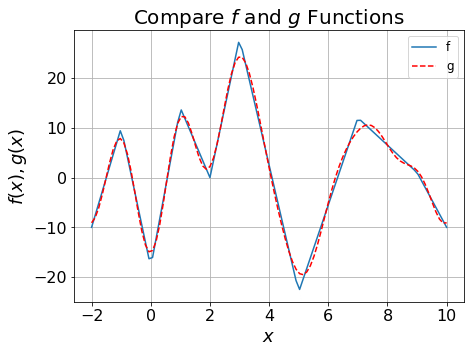

In [6]:
'''Plot comparison of f and g_vec'''

n_pts = 100
plot_pts = np.linspace(min_x, max_x, n_pts)

(a_mtrx, _) = build_fourier_linear_system(mu, N, plot_pts, np.zeros(n_pts))

g_vec = a_mtrx @ c_vec

f.plot(g=(plot_pts,g_vec), n_plot_pts=n_pts, title='Compare $f$ and $g$ Functions')

### [Errors](#toc)<a id="error"></a>

In [7]:
'''Local error depends on the number of sampling points'''

n_pts = 50

x_pts = np.linspace(min_x, max_x, n_pts)

f_vec = f.values(x_pts)

(a_mtrx, _) = build_fourier_linear_system(mu, N, x_pts, np.zeros(x_pts.size))
g_vec = a_mtrx @ c_vec

shift = False

if shift:
    min_val = min(min(f_vec), min(g_vec))
    v_shift = min_val
    f_vec += abs(v_shift+1)
    g_vec += abs(v_shift+1)

print('mean local rel error [%] = ', np.mean(abs((g_vec-f_vec)/f_vec*100.0)))
print('std local rel error [%] = ', np.std(abs((g_vec-f_vec)/f_vec*100.0)))
print('max local rel error [%] = ', np.max(abs((g_vec-f_vec)/f_vec*100.0)))
print('min local rel error [%] = ', np.min(abs((g_vec-f_vec)/f_vec*100.0)))

mean local rel error [%] =  29.355208496737987
std local rel error [%] =  90.3386992674571
max local rel error [%] =  639.8875854836876
min local rel error [%] =  0.035937632185606916


In [8]:
'''Integral (area) error'''

from scipy.integrate import quad

def f_integrand(x):
    return f.values(np.array(x))
def g_integrand(x):
    (a_mtrx, _) = build_fourier_linear_system(mu, N, np.array(x), np.zeros(1))
    g_vec = a_mtrx @ c_vec
    return g_vec

f_integral = quad(f_integrand, min_x, max_x)
print('Area under f =', f_integral)

g_integral = quad(g_integrand, min_x, max_x)
print('Area under g =', g_integral)

print('rel error [%] = ', abs(g_integral[0]-f_integral[0])/f_integral[0]*100)

Area under f = (17.499999999999982, 1.942890293094022e-14)
Area under g = (17.2561394247453, 1.3251763575361508e-10)
rel error [%] =  1.3934890014553314


The Lebesgue integral norm, $L_2(\Omega)$, of a function is defined as

\begin{equation*}
 \norm{f}_{L_2(\Omega)} = \sqrt{\int\limits_{\Omega} \, f^2(x)\,dx}
\end{equation*}

and can be used for error estimation of function approximation. This norm and other equivalent norms play an important role in functional theory and finite element methods.

In [9]:
'''L2 norm error'''

from scipy.integrate import quad
import math

print('||f||_L2 =', f.l2_norm[0])
#print('quadrature error =', error)

def g2_integrand(x):
    (a_mtrx, _) = build_fourier_linear_system(mu, N, np.array(x), np.zeros(1))
    g_vec = a_mtrx @ c_vec
    return g_vec**2

print('')

g2_integral, error = quad(g2_integrand, min_x, max_x, limit=100)
print('||g||_L2 =', math.sqrt(g2_integral))
#print('quadrature error =', error)

def f_minus_g_2_integrand(x):
    (a_mtrx, _) = build_fourier_linear_system(mu, N, np.array(x), np.zeros(1))
    g_vec = a_mtrx @ c_vec
    f_x = f.values(np.array(x))
    return (f_x-g_vec)**2

print('')

f_minus_g_2_integral, error = quad(f_minus_g_2_integrand, min_x, max_x, limit=100)
print('||f-g||_L2 =', math.sqrt(f_minus_g_2_integral))
#print('quadrature error =', error)

print('')
print('Relative error [%] =', math.sqrt(f_minus_g_2_integral)/f.l2_norm[0]*100)

||f||_L2 = 37.09896674212549

||g||_L2 = 37.027252294267676

||f-g||_L2 = 3.6160003468634705

Relative error [%] = 9.74690311996625


## [Least-Squares Approxmation w/ Polynomial Basis Functions](#toc)<a id="poly"></a>

A polynomial "Lagrange" basis functions can also be used

\begin{equation*}
   V := \{x^k \, \mid \, k=0,\ldots,N\}
\end{equation*}

where $N$ is the degree of the basis. This set of basis functions is much less flexible than the Fourier counterpart, unless the function to be approximated is a polynomial function.

In [10]:
'''Build the approximant polynomial function'''

try:    
    from engy_5310.toolkit import build_poly_linear_system   
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
degree = 15

(a_mtrx, f_vec) = build_poly_linear_system(degree, collocation_pts, f.values(collocation_pts) )

In [11]:
'''Compute optimal coefficient vector'''

#c_vec = solve(a_mtrx.transpose()@a_mtrx, a_mtrx.transpose()@f_vec, pivot_tol=1e-9, zero_tol=1e-3)

import numpy.linalg as linalg
c_vec = linalg.solve(a_mtrx.transpose()@a_mtrx, a_mtrx.transpose()@f_vec)

### [Results](#toc)<a id="polyres"></a>

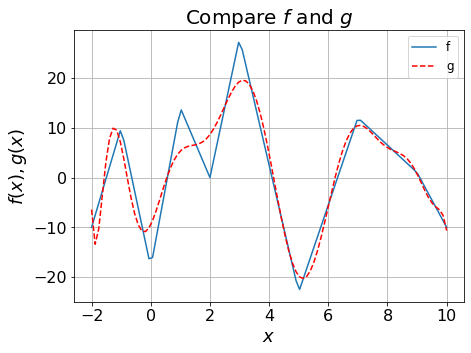

In [12]:
'''Plot comparison of f and g_vec'''

n_pts = 100
plot_pts = np.linspace(min_x, max_x, n_pts)

(a_mtrx, _) = build_poly_linear_system(degree, plot_pts, np.zeros(n_pts))

g_vec = a_mtrx @ c_vec

f.plot(g=(plot_pts,g_vec), n_plot_pts=n_pts, title='Compare $f$ and $g$')

In [13]:
'''L2 norm error'''

from scipy.integrate import quad
import math

print('||f||_L2 =', f.l2_norm[0])
#print('quadrature error =', error)

def g2_integrand(x):
    (a_mtrx, _) = build_poly_linear_system(degree, np.array(x), np.zeros(1))
    g_vec = a_mtrx @ c_vec
    return g_vec**2

print('')

g2_integral, error = quad(g2_integrand, min_x, max_x, limit=100)
print('||g||_L2 =', math.sqrt(g2_integral))
#print('quadrature error =', error)

def f_minus_g_2_integrand(x):
    (a_mtrx, _) = build_poly_linear_system(degree, np.array(x), np.zeros(1))
    g_vec = a_mtrx @ c_vec
    f_x = f.values(np.array(x))
    return (f_x-g_vec)**2

print('')

f_minus_g_2_integral, error = quad(f_minus_g_2_integrand, min_x, max_x, limit=100)
print('||f-g||_L2 =', math.sqrt(f_minus_g_2_integral))
#print('quadrature error =', error)

print('')
print('Relative error [%] =', math.sqrt(f_minus_g_2_integral)/f.l2_norm[0]*100)

||f||_L2 = 37.09896674212549

||g||_L2 = 35.40040078477293

||f-g||_L2 = 11.081778614514013

Relative error [%] = 29.87085514144729


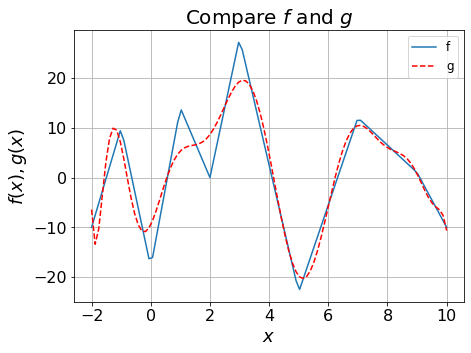

In [12]:
'''Plot comparison of f and g_vec'''

n_pts = 100
plot_pts = np.linspace(min_x, max_x, n_pts)

(a_mtrx, _) = build_poly_linear_system(degree, plot_pts, np.zeros(n_pts))

g_vec = a_mtrx @ c_vec

f.plot(g=(plot_pts,g_vec), n_plot_pts=n_pts, title='Compare $f$ and $g$')

### [Results](#toc)<a id="polyres"></a>

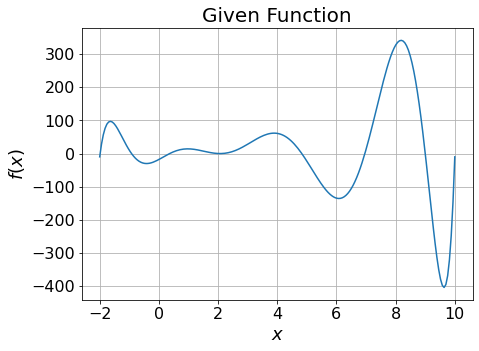

In [15]:
'''Consider another function'''

f = Function(shape_pts, type='poly')
  
f.plot(n_plot_pts=200, title='Given Function')

In [42]:
'''Build the approximant polynomial function'''
   
degree = 8

(a_mtrx, f_vec) = build_poly_linear_system(degree, collocation_pts, f.values(collocation_pts) )

In [43]:
'''Compute optimal coefficient vector'''

#c_vec = solve(a_mtrx.transpose()@a_mtrx, a_mtrx.transpose()@f_vec, pivot_tol=1e-9, zero_tol=1e-3)

import numpy.linalg as linalg
c_vec = linalg.solve(a_mtrx.transpose()@a_mtrx, a_mtrx.transpose()@f_vec)

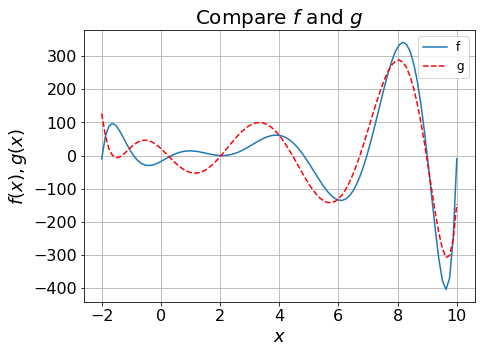

In [44]:
'''Plot comparison of f and g_vec'''

n_pts = 100
plot_pts = np.linspace(min_x, max_x, n_pts)

(a_mtrx, _) = build_poly_linear_system(degree, plot_pts, np.zeros(n_pts))

g_vec = a_mtrx @ c_vec

f.plot(g=(plot_pts,g_vec), n_plot_pts=n_pts, title='Compare $f$ and $g$')

In [45]:
'''L2 norm error'''

from scipy.integrate import quad
import math

print('||f||_L2 =', f.l2_norm[0])
#print('quadrature error =', error)

print('')

g2_integral, error = quad(g2_integrand, min_x, max_x, limit=100)
print('||g||_L2 =', math.sqrt(g2_integral))
#print('quadrature error =', error)

print('')

f_minus_g_2_integral, error = quad(f_minus_g_2_integrand, min_x, max_x, limit=100)
print('||f-g||_L2 =', math.sqrt(f_minus_g_2_integral))
#print('quadrature error =', error)

print('')
print('Relative error [%] =', math.sqrt(f_minus_g_2_integral)/f.l2_norm[0]*100)

||f||_L2 = 473.34482070463

||g||_L2 = 429.63022802116205

||f-g||_L2 = 180.48323182346277

Relative error [%] = 38.12933487997017
